In [ ]:
# BL531 commissioning
# matt landsman (mrlandsman@lbl.gov)
# may 7, 2024

In [1]:
import epics
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import sleep as time_sleep
import pandas as pd
import fabio
import pyFAI
from pyFAI.calibrant import get_calibrant
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from matplotlib.colors import LogNorm

from tqdm import tqdm

%matplotlib inline

In [ ]:
# bar 1
    # AgB
    # Copper acetate powder
    # Copper nanoparticles (50 nm, from B30)
# bar 2
    # Noah's sample #1
    # Noah's sample #2
# bar 3
    # cameron01
    # cameron00
    # cameron02

# bar 4
    # cameron03
    # cameron04
    # cameron05

# bar 5
    # cameron06
    # cameron07
    # FeOH3 + boric acid


# I did Cu K-edge measurements on bars 1 and 2
# I did hard x-ray (9 keV) SAXS+WAXS on bars 3, 4, 5
# For bar 5, I measured last sample at Fe K-edge    

In [ ]:
# pumping/venting directions:
    # load sample
    # turn on roughing pump (make sure the N2 is off and the sample chamber is closed, pressure should decrease when you turn the pump on)
    # wait 30-45 min until you reach <400 mTorr
    # turn on turbomolecular pump
    # turn on chiller
    # once gauge reads zero, you can turn on the camera switch
    # search hutch
    # start up camera on terminal
        # ./runtvx --> good to start here to take test images and make sure detector is good to go
        # then close the runtvx terminal and run "xterm -geometry 80x40+20-5 -e camserver &" to work in epics

# venting directions:
    # close shutter and enter hutch
    # switch camera off --> check the computer to ensure its disconnected
    # switch chiller off
    # turn off the turbomolecular pump, wait for LEVITATION
    # turn off the roughing pump
    # open N2 valve
    # open the sample chamber so pressure doesnt build up once vacuum is gone
    # once the sample chamber opens, turn off the N2 and leave chamber vented 

In [ ]:
# some useful epics commands
# epics.caput('bl531_xps1:mono_angle_deg', mono_deg(10000))
# epics.caget('bl531_xps1:mono_angle_deg')
# mono_deg(10000)

In [2]:
# define mono angle to energy conversion

#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg
mono_deg(10000)

#energy_eV = lambda mono_deg_input: (mono_deg_input - mono_offset_deg)
#energy_eV(26)


24.191936153850616

In [ ]:
# set energy

#epics.caget('bl531_xps1:mono_angle_deg') #, mono_angles_deg[i_a])

input_mono_angle = mono_deg(7000)

#input_mono_angle = 26


epics.caput('bl531_xps1:mono_angle_deg', input_mono_angle)


In [150]:
epics.caget('bl531_xps1:mono_angle_deg')


29.195768993164748

In [38]:
epics.caput('bl531_xps1:mono_angle_deg', 33.85836713655516
) #32.0296573004108
 #36.08313738024824) #29.195768993164748)# 25.479182679068188) #26.741337259308523)

1

In [163]:
epics.caput('bl531_xps1:mono_angle_deg', mono_deg(7150))


1

In [148]:
mono_deg(9000)

25.479182679068188

In [ ]:
filepath

In [ ]:
last_filename

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# sample01 --> AgB 

In [9]:
epics.caget('13PIL1:cam1:AcquireTime')

cannot connect to 13PIL1:cam1:AcquireTime


In [4]:
# single image acquisition on saxs detector
aqtime_s = 0.1
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

cannot connect to 13PIL1:cam1:AcquireTime
cannot connect to 13PIL1:cam1:AcquirePeriod
cannot connect to 13PIL1:cam1:Acquire
cannot connect to 13PIL1:cam1:FullFileName_RBV


TypeError: cannot convert 'NoneType' object to bytes

In [ ]:
# display 2d image 

#filepath = '/mnt/pilatus/' + 'BinaryNP_231222_WAXS_4802.tif'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'
filepath = last_filename[:-1]
filepath = '/mnt/data531/saxs_AgB_8650eV_1sec_5035.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [ ]:
np.percentile(im_np,99.999)   # this value should be below 1 million
#np.max(im_np)

In [ ]:
np.average(im_np)

In [151]:
# nexafs scans

input_energies = np.linspace(8750, 8950, 201)   # nexafs Cu K-edge
input_energies = np.linspace(8800, 8850, 51)   # nexafs Cu K-edge


input_energies = np.linspace(6950, 7150, 101)   # nexafs Fe K-edge



time_sleep_variable = 1


mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0
epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in tqdm(np.arange(len(mono_angles_deg))):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(time_sleep_variable*2)
    nexafs_reading_1 = epics.caget('bl201-beamstop:current')
    time_sleep(time_sleep_variable)
    nexafs_reading_2 = epics.caget('bl201-beamstop:current')
    time_sleep(time_sleep_variable)
    nexafs_reading_3 = epics.caget('bl201-beamstop:current')
    time_sleep(time_sleep_variable)
    nexafs_reading_4 = epics.caget('bl201-beamstop:current')
    time_sleep(time_sleep_variable)
    pd_val_nA[i_a] = nexafs_reading_1 + nexafs_reading_2 + nexafs_reading_3 + nexafs_reading_4


file_name = 'cu_test'
np.savetxt(f'/home/bl531/bl531_commissioning/20240424ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

print('done')







100%|██████████| 101/101 [10:06<00:00,  6.01s/it]

done


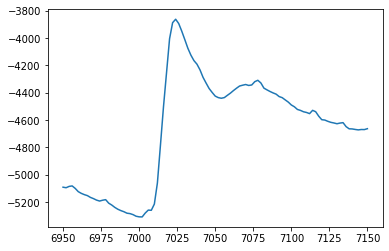

In [152]:
plt.plot(input_energies[:], pd_val_nA[:])

In [131]:

np.savetxt(f'/home/bl531/bl531_commissioning/20240424ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)


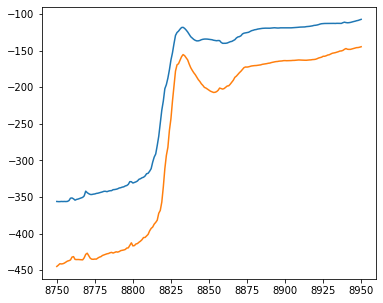

In [108]:
# lets look at the nexafs scans

mrl_save_path = '/home/bl531/bl531_commissioning/20240507ML_commissioning/'

spectra_files = sorted(f for f in os.listdir(mrl_save_path) if '_CuKedge' in f)

fig, ax = plt.subplots(figsize=(6,5))

for spec in spectra_files:
    spec_data = np.loadtxt(os.path.join(mrl_save_path, spec))

    energy = spec_data[:,0]
    mono_angle = spec_data[:,1]
    photodiode = spec_data[:,2]


    ax.plot(energy, photodiode, label=spec)
    #ax.set_xlim([8800, 8880])
   # ax.legend()

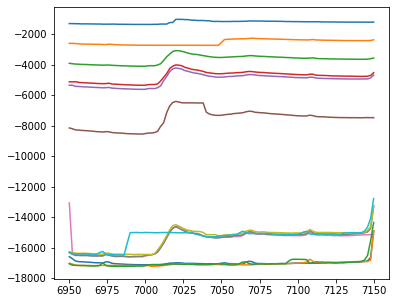

In [101]:
# lets look at the nexafs scans

mrl_save_path = '/home/bl531/bl531_commissioning/20240424ML_commissioning/'

spectra_files = sorted(f for f in os.listdir(mrl_save_path) if '_nexafs' in f)

fig, ax = plt.subplots(figsize=(6,5))

for spec in spectra_files:
    spec_data = np.loadtxt(os.path.join(mrl_save_path, spec))

    energy = spec_data[:,0]
    mono_angle = spec_data[:,1]
    photodiode = spec_data[:,2]


    ax.plot(energy, photodiode, label=spec)
   # ax.legend()

In [93]:
# pilatus single image acquisition
aqtime_s = 4
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

/mnt/data531/scan14_saxs_dark_4.0sec_5365.tif 


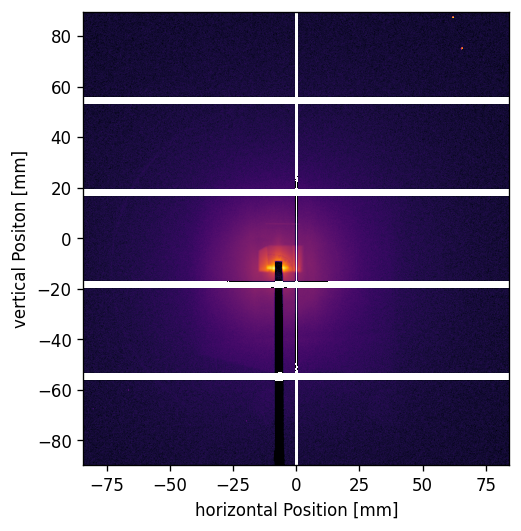

In [102]:
# display 2d image 


filepath = last_filename[:-1]
#filepath = '/mnt/data531/scan05_saxs_FeOH3_2sec_5141.tif'
filepath = '/mnt/data531/scan05_saxs_FeOH3_2sec_5141.tif'


# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

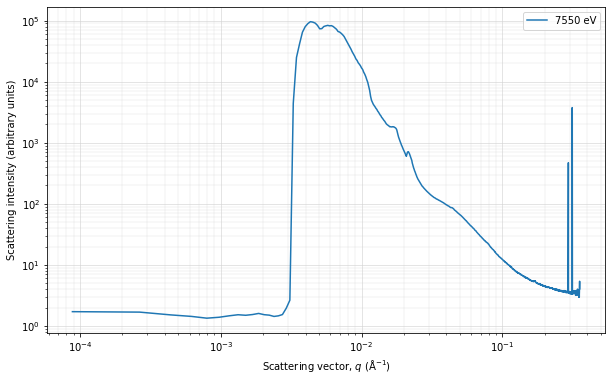

In [103]:
# radial integration of a single pilatus image

#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_10000eV/scan07_saxs_tulasi-PET-ctrl_4891.tif'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_dark_4898.tif'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'

az_range=[-180,180]
fig, ax = plt.subplots(figsize=(10,6))
#qvector_list = []
#radint_list = []
#energy_list = []
#for idx, image in tqdm(enumerate(images[:])):

#mono_angle = float(image[ image.find('deg') - 4: image.find('deg')])
#energy = calculate_output_energy(mono_angle)

# calibration performed in pyfai-calib2 by mrl on 4/22/24
dist = 1.47
poni1 = 0.10065476219862225
poni2 = 0.07695294434659085
rot1 = 0
rot2 = 0
rot3 = 0

energy = 7550

wavelength = ( (4.1357 * (10**-15)) * (2.9979 * (10**8))) / energy
calibrant = pyFAI.calibrant.get_calibrant("AgBh")
calibrant.wavelength = wavelength
detector = pyFAI.detectors.Pilatus1M(pixel1=0.000172, pixel2=0.000172, max_shape=(1043, 981))
ai = AzimuthalIntegrator(dist=dist, detector=detector, wavelength=wavelength, poni1=poni1, poni2=poni2, rot1=rot1, rot2=rot2, rot3=rot3)
#ai.maskfile = os.path.join(master_path, 'waxs_mask_mrl_april2024.edf')

im_path = os.path.join(filepath)
im_data = fabio.open(im_path)
im_array = im_data.data
im_array[im_array < 1] = 1
im_reduced = ai.integrate1d(im_array, npt=2000, azimuth_range=az_range)
qvector = im_reduced[0] / 10
intensity = im_reduced[1] # / diode_value

#log_intensity = np.log10(intensity)
#log_intensity_offset = log_intensity - 1 * idx
#intensity_offset = 10**(log_intensity_offset)
#intensity = intensity_offset

#qvector_list.append(qvector)
#radint_list.append(intensity)
#energy_list.append(energy)
energy_rounded = round(energy, 0)
ax.plot(qvector, intensity, label=f'{energy_rounded} eV')
ax.set_xscale('log')
ax.set_yscale('log')    
#ax.set_title(f'Fe(OH)3 Sample\nRadially integrated WAXS profile\nEnergy={energy} eV')
ax.set_xlabel(r'Scattering vector, $q \ (\mathrm{\AA^{-1}})$')
ax.set_ylabel('Scattering intensity (arbitrary units)')
ax.grid(which='major', color='lightgrey', linewidth=0.6); ax.grid(which='minor', color='lightgrey', linewidth=0.3)
ax.legend()
plt.show()

#if flag_save:
#    path_saxs_plot = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.tif')
#    path_saxs_txt = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.txt')
#    fig.savefig(path_saxs_plot, bbox_inches='tight', dpi=300)
#    np.savetxt(path_saxs_txt, np.vstack((qvector, intensity)).T)



In [79]:
# saxs energy scan

Es_eV = np.linspace(6950, 7150, 101)        # same energy range/resolution as nexafs



epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(5)
filenames = ()
for i_e in tqdm(range(len(Es_eV))):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    time_sleep(2)


    aqtime_s = 2
    epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
    epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()
    filenames += (last_filename,)



100%|██████████| 101/101 [11:48<00:00,  7.01s/it]


In [75]:
np.percentile(im_np, 99.99)

282281.15079983603

In [29]:
epics.caget('bl531_xps1:mono_angle_deg')

28.842117652343042

In [30]:
mono_deg(7150)

28.842117652343042

In [82]:
img = ()
for i_e in range(len(Es_eV)):
    filepath = filenames[i_e][:-1]
    # read the image
    im_tiff = Image.open(filepath)
    # make the image a numpy array so that we can process it
    im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
    img += (im_np,)


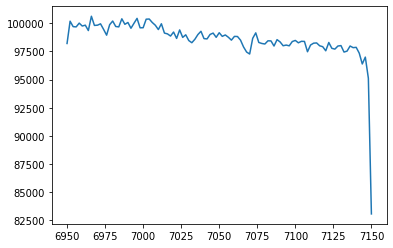

In [83]:
# tracking flux on top of detector to see if we can see fluorescence nexafs

fig, ax = plt.subplots()

flux = Es_eV*0
for i_e in range(len(Es_eV)):
    flux[i_e] = np.sum(img[i_e][0:200, 0:200])

ax.plot(Es_eV, flux)
#ax.set_xlim([0,100])
#ax.set_ylim([2.4e6, 2.8e6])


In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# below is the code from april 22, 2024

In [ ]:
# execute nexafs scan (to collect on photodiode) across an inputted energy range

input_energies = np.linspace(8965, 8995, 101)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')

In [ ]:
# make a quick plot of the photodiode signal

plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan01_nexafs_CopperFoil_photodiode'
#file_name = 'scan02_nexafs_CopperFoil_photodiode_dark'
#file_name = 'scan03_nexafs_CopperFoil_photodiode_dark2'

#np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# now i've pulled vacuum on a direct beam sample
# and i ran tulasis two PET-SeNP samples using these cells

In [ ]:
# lets do a wide energy scan on the photodiode to see what the bkg on is for a direct beam   

input_energies = np.linspace(5000, 11000, 201)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')


# make a quick plot of the photodiode signal
plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan04_nexafs_directbeam_photodiode_dark'
file_name = 'scan05_nexafs_directbeam_photodiode'

#np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# pilatus time :)  single image acquisition
aqtime_s = 1
epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
epics.caput('13PIL1:cam1:Acquire',1)
time_sleep(5)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()
print(last_filename)

In [ ]:
# display 2d image 

#filepath = '/mnt/pilatus/' + 'BinaryNP_231222_WAXS_4802.tif'
#filepath = '/mnt/pilatus/' + 'FeNOM_20231221_3756.tif'
#filepath = 'afp://bl531user@bl531data.local/User_Data/' + last_filename[13:-1]
filepath = f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{last_filename[13:-1]}'
#filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan06_saxs_directbeam_5000-11000eV/scan06_saxs_directbeam_4882.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_4894.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'


# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
#im_np[np.where(im_np>100000.0)] =0

dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

#mask = im_np > np.max(im_np)
#im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno', norm=LogNorm())
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [ ]:
# check that you are not oversaturating detector... if so, adjust exposure time 

np.percentile(im_np,99.9)   # this value should be below 1 million

In [ ]:
# pilatus energy scan

Es_eV = np.linspace(5000, 11000, 61)

epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(5)
filenames = ()
for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    time_sleep(2)

    aqtime_s = 1
    epics.caput('13PIL1:cam1:AcquireTime', aqtime_s * 1.5)
    epics.caput('13PIL1:cam1:AcquirePeriod', aqtime_s)
    epics.caput('13PIL1:cam1:Acquire',1)
    time_sleep(5)

    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()[13:-1]
    filenames += (last_filename,)


In [ ]:
# radial integration of a single pilatus image

filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan07_saxs_tulasi-PET-ctrl_10000eV/scan07_saxs_tulasi-PET-ctrl_4891.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_dark_4898.tif'
filepath = '/home/bl531/bl531_commissioning/20240422ML_commissioning/scan08_saxs_tulasi-PET-SeNP2_4899.tif'

az_range=[-180,180]
fig, ax = plt.subplots(figsize=(10,6))
#qvector_list = []
#radint_list = []
#energy_list = []
#for idx, image in tqdm(enumerate(images[:])):
mono_angle = 24.19
energy = 10000
#mono_angle = float(image[ image.find('deg') - 4: image.find('deg')])
#energy = calculate_output_energy(mono_angle)

# calibration performed in pyfai-calib2 by mrl on 4/22/24
dist = 1.47
poni1 = 0.10065476219862225
poni2 = 0.07695294434659085
rot1 = 0
rot2 = 0
rot3 = 0

wavelength = ( (4.1357 * (10**-15)) * (2.9979 * (10**8))) / energy
calibrant = pyFAI.calibrant.get_calibrant("AgBh")
calibrant.wavelength = wavelength
detector = pyFAI.detectors.Pilatus1M(pixel1=0.000172, pixel2=0.000172, max_shape=(1043, 981))
ai = AzimuthalIntegrator(dist=dist, detector=detector, wavelength=wavelength, poni1=poni1, poni2=poni2, rot1=rot1, rot2=rot2, rot3=rot3)
#ai.maskfile = os.path.join(master_path, 'waxs_mask_mrl_april2024.edf')

im_path = os.path.join(filepath)
im_data = fabio.open(im_path)
im_array = im_data.data
im_array[im_array < 1] = 1
im_reduced = ai.integrate1d(im_array, npt=2000, azimuth_range=az_range)
qvector = im_reduced[0] / 10
intensity = im_reduced[1] # / diode_value

#log_intensity = np.log10(intensity)
#log_intensity_offset = log_intensity - 1 * idx
#intensity_offset = 10**(log_intensity_offset)
#intensity = intensity_offset

#qvector_list.append(qvector)
#radint_list.append(intensity)
#energy_list.append(energy)
energy_rounded = round(energy, 0)
ax.plot(qvector, intensity, label=f'{energy_rounded} eV')
ax.set_xscale('log')
ax.set_yscale('log')    
#ax.set_title(f'Fe(OH)3 Sample\nRadially integrated WAXS profile\nEnergy={energy} eV')
ax.set_xlabel(r'Scattering vector, $q \ (\mathrm{\AA^{-1}})$')
ax.set_ylabel('Scattering intensity (arbitrary units)')
ax.grid(which='major', color='lightgrey', linewidth=0.6); ax.grid(which='minor', color='lightgrey', linewidth=0.3)
ax.legend()
plt.show()

#if flag_save:
#    path_saxs_plot = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.tif')
#    path_saxs_txt = os.path.join(save_path, f'{sample_folder}_saxs_{energy}eV.txt')
#    fig.savefig(path_saxs_plot, bbox_inches='tight', dpi=300)
#    np.savetxt(path_saxs_txt, np.vstack((qvector, intensity)).T)



In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# now i have the Copper Foil back in the chamber and i pulled vacuum
# want to try some spectroscopy (NEXAFS, EXAFS) at Cu K-edge

In [ ]:
# lets look at the Cu K-edge

input_energies = np.linspace(8965, 8995, 101)
mono_angles_deg = mono_deg(input_energies)
pd_val_nA = mono_angles_deg*0

epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')


# make a quick plot of the photodiode signal
plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')
plt.show()

# save data since photodiode signals are not archived (i think)!
file_name = 'scan12_nexafs_CuFoil-vacuum_photodiode_5sec'



np.savetxt(f'/home/bl531/bl531_commissioning/20240422ML_commissioning/{file_name}.txt', np.vstack((input_energies, mono_angles_deg, pd_val_nA)).T)

In [ ]:
# 0.5 sec photodiode scan for reference (to compare to 5 sec scan above)

plt.plot(input_energies,pd_val_nA)
plt.xlabel('Beamline Energy (eV)')
plt.ylabel('Beamstop Diode Intensity [nA]')

plt.show()

In [ ]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# antoines code from 20240422ML_calibration.ipynb

In [ ]:
# testing EPICS with the monochromator
epics.caget('bl531_xps1:mono_angle_deg')

In [ ]:

epics.caget('bl201-beamstop:current')

In [ ]:
import matplotlib.pyplot as plt
from time import sleep as time_sleep

mono_angles_deg = np.linspace(25,26,101)
pd_val_nA = mono_angles_deg*0


epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[0])
time_sleep(5)
for i_a in np.arange(len(mono_angles_deg)):
    epics.caput('bl531_xps1:mono_angle_deg', mono_angles_deg[i_a])
    time_sleep(0.5)
    pd_val_nA[i_a] = epics.caget('bl201-beamstop:current')




In [ ]:
plt.plot(mono_angles_deg,pd_val_nA)
plt.xlabel('Mono angle [deg]')
plt.ylabel('beamstop diode intensity [nA]')
plt.show()


In [ ]:
pd_val_nA